# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [1]:
# --- Extension Setup ---
%load_ext autoreload
%load_ext line_profiler
%autoreload 3 -p

# --- Module Imports ---
import sys
sys.path.append("..")  # Adjust if your afml repo is nested differently

# --- Autoreload Target ---
%aimport afml

# --- AFML Initialization ---
# Setup with auto-reload enabled
import afml

# Enhanced setup with all features
components = afml.setup_jupyter(
    enable_mlflow=True,      # Set True if you have mlflow installed
    enable_monitoring=True,    # Cache analytics
)

# --- Environment Diagnostics ---
from pathlib import Path
print(f"Working Dir: {Path.cwd()}")


2025-11-03 22:21:16.514 | DEBUG    | afml.cache:<module>:389 - Auto-reload not available (install watchdog for file watching)
2025-11-03 22:21:16.515 | DEBUG    | afml.cache:<module>:688 - Enhanced cache features available:
2025-11-03 22:21:16.516 | DEBUG    | afml.cache:<module>:689 -   - Robust cache keys for NumPy/Pandas
2025-11-03 22:21:16.525 | DEBUG    | afml.cache:<module>:690 -   - MLflow integration: ✓
2025-11-03 22:21:16.527 | DEBUG    | afml.cache:<module>:691 -   - Backtest caching: ✓
2025-11-03 22:21:16.529 | DEBUG    | afml.cache:<module>:692 -   - Cache monitoring: ✓
2025-11-03 22:21:17.538 | DEBUG    | afml.cache:_configure_numba:59 - Numba cache configured: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-11-03 22:21:17.541 | INFO     | afml.cache:initialize_cache_system:308 - AFML cache system initialized:
2025-11-03 22:21:17.542 | INFO     | afml.cache:initialize_cache_system:309 -   Joblib cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
2

Working Dir: c:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\notebooks


In [2]:
import time
import warnings
import winsound
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import MetaTrader5 as mt5
from sklearn.base import clone
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
)
from sklearn.tree import DecisionTreeClassifier

from afml.cross_validation import (
    PurgedKFold,
    PurgedSplit,
    analyze_cross_val_scores,
    ml_cross_val_score,
    probability_weighted_accuracy,
)
from afml.cross_validation.scoring import probability_weighted_accuracy
from afml.data_structures.bars import *
from afml.ensemble.sb_bagging import (
    SequentiallyBootstrappedBaggingClassifier,
    compute_custom_oob_metrics,
    estimate_ensemble_size,
)
from afml.labeling.triple_barrier import (
    add_vertical_barrier,
    get_event_weights,
    triple_barrier_labels,
)
from afml.mt5.load_data import get_bars, login_mt5, get_ticks, save_data_to_parquet
from afml.sample_weights.optimized_attribution import (
    get_weights_by_time_decay_optimized,
)

# from afml.sampling import get_ind_mat_average_uniqueness, get_ind_matrix, seq_bootstrap
from afml.strategies import (
    BollingerStrategy,
    MACrossoverStrategy,
    create_bollinger_features,
    get_entries,
    ma_crossover_feature_engine,
)
from afml.util import get_daily_vol, value_counts_data

warnings.filterwarnings("ignore")
# plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("dark_background")


In [3]:
# Add to your startup script or notebook
from afml.cache import print_cache_health, get_cache_efficiency_report

# Check cache health anytime
print_cache_health()

# Find functions with low hit rates or high call counts
df = get_cache_efficiency_report()
df.sort_values('calls', ascending=False).head(10)


CACHE HEALTH REPORT

Overall Statistics:
  Total Functions:     3
  Total Calls:         153
  Overall Hit Rate:    98.0%
  Total Cache Size:    0.00 MB

Top Performers (by hit rate):
  1. triple_barrier_labels: 99.3% (151 calls)
  2. create_bollinger_features: 0.0% (1 calls)
  3. get_event_weights: 0.0% (1 calls)

Worst Performers (by hit rate):
  1. triple_barrier_labels: 99.3% (151 calls)
  2. create_bollinger_features: 0.0% (1 calls)
  3. get_event_weights: 0.0% (1 calls)

Recommendations:
  1. Excellent hit rate (>90%)! Cache system is performing well.




,function,calls,hits,misses,hit_rate,avg_time_ms,cache_size_mb,last_access
1,afml.labeling.triple_barrier.triple_barrier_la...,151,150,1,99.3%,N/A,N/A,N/A
0,afml.strategies.bollinger_features.create_boll...,1,0,1,0.0%,N/A,N/A,N/A
2,afml.labeling.triple_barrier.get_event_weights,1,0,1,0.0%,N/A,N/A,N/A


## 1. Data Preparation

In [4]:
symbol = "EURUSD"
start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2023-12-31"

## 2. Bollinger Band Strategy

In [5]:
bb_timeframe = "M5"
file = Path(r"..\data\EURUSD_M5_time_2018-01-01-2024-12-31.parq")
bb_time_bars = pd.read_parquet(file)

In [7]:
bb_period, bb_std = 20, 2 # Bollinger Band parameters
bb_strategy = BollingerStrategy(window=bb_period, num_std=bb_std)
bb_lookback = 10
bb_pt_barrier, bb_sl_barrier, bb_time_horizon = (1, 2, dict(days=1))
min_ret = 5e-5
bb_vol_multiplier = 1

### Time-Bars

In [8]:
bb_side = bb_strategy.generate_signals(bb_time_bars)
bb_df = bb_time_bars.loc[sample_start : sample_end]

print(f"{bb_strategy.get_strategy_name()} Signals:")
value_counts_data(bb_side.reindex(bb_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = 100
vol_target = get_daily_vol(bb_df.close, vol_lookback) * bb_vol_multiplier
close = bb_df.close
_, t_events = get_entries(bb_strategy, bb_df, filter_threshold=vol_target)

vertical_barriers = add_vertical_barrier(t_events, close, **bb_time_horizon)

Bollinger_w20_std2 Signals:

        count  proportion
side                     
 0    373,536    0.842213
-1     35,095    0.079129
 1     34,886    0.078658



2025-11-03 20:29:13.737 | INFO     | afml.filters.filters:cusum_filter:151 - 19,458 CUSUM-filtered events
2025-11-03 20:29:13.884 | INFO     | afml.strategies.signal_processing:get_entries:105 - Bollinger_w20_std2 | 10,384 (14.84%) trade events selected by CUSUM filter using series.


#### Feature Engineering

In [9]:
bb_feat = create_bollinger_features(bb_time_bars, bb_period, bb_std)
bb_feat_time = bb_feat.join(bb_side, how="inner")
bb_feat_time.info()
# not_stationary = is_stationary(bb_feat_time)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516825 entries, 2018-01-02 23:20:00 to 2024-12-31 00:00:00
Data columns (total 49 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   spread               516825 non-null  float32
 1   vol                  516825 non-null  float32
 2   h1_vol               516825 non-null  float32
 3   h4_vol               516825 non-null  float32
 4   d1_vol               516825 non-null  float32
 5   ret                  516825 non-null  float32
 6   ret_5                516825 non-null  float32
 7   ret_10               516825 non-null  float32
 8   ret_1_lag_1          516825 non-null  float32
 9   ret_5_lag_1          516825 non-null  float32
 10  ret_10_lag_1         516825 non-null  float32
 11  ret_1_lag_2          516825 non-null  float32
 12  ret_5_lag_2          516825 non-null  float32
 13  ret_10_lag_2         516825 non-null  float32
 14  ret_1_lag_3          516825 non-nu

#### Triple-Barrier Method

In [ ]:
bb_events_tb = triple_barrier_labels(
    close,
    vol_target,
    t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    vertical_barrier_zero=True,
    verbose=False,
)

bb_events_tb_time = bb_events_tb.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tb['bin'], verbose=True)

weights = get_event_weights(bb_events_tb, close)
av_uniqueness = weights['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h={'days': 1}):

     count  proportion
bin                   
-1   5,109    0.505741
 1   4,993    0.494259

Average Uniqueness: 0.7465


In [ ]:
bb_events_tb = triple_barrier_labels(
    close,
    vol_target,
    t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=True,
    verbose=False,
)

bb_events_tb_time_meta = bb_events_tb.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tb['bin'], verbose=True)

weights = get_event_weights(bb_events_tb, close)
av_uniqueness = weights['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h={'days': 1}):

     count  proportion
bin                   
1    6,506    0.626601
0    3,877    0.373399

Average Uniqueness: 0.5488


#### Primary Model - CV of Weighting Methods

In [12]:
from os import cpu_count


# Reserve 1 CPU if you want to do something else during training,
# otherwise set to -1
N_JOBS = cpu_count() - 1
N_ESTIMATORS = 100
random_state = 7

In [13]:
cont = bb_events_tb_time.copy()
X = bb_feat_time.reindex(cont.index)
y = cont["bin"]
t1 = cont["t1"]

test_size = 0.2

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )

cont_train = get_event_weights(cont.iloc[train], bb_df.close)
bb_cont_train = cont_train.copy()

n_splits = 5
pct_embargo = 0.01
cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)

In [44]:
avg_u = cont_train.tW.mean()
print(f"Average Uniqueness in Training Set: {avg_u:.4f}")

weighting_schemes = {
    "unweighted": pd.Series(1., index=cont_train.index),
    "uniqueness": cont_train["tW"],
    "return": cont_train["w"],
    }

decay_factors = [0.0, 0.25, 0.5, 0.75]
time_decay_weights = {}
for time_decay in decay_factors:
    decay_w = get_weights_by_time_decay_optimized(
                triple_barrier_events=cont,
                close_index=close.index,
                last_weight=time_decay,
                linear=True,
                av_uniqueness=cont_train["tW"],
            )
    time_decay_weights[f"decay_{time_decay}"] = decay_w
        
# for k, v in time_decay_weights.items():
#     if k.startswith("linear"):
#         weighting_schemes[k] = v

weighting_schemes.keys()

Average Uniqueness in Training Set: 0.7473


dict_keys(['unweighted', 'uniqueness', 'return'])

##### Selection of Best Model

In [45]:
min_w_leaf = 0.05
max_depth = 6

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=N_ESTIMATORS,
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=max_depth,
    n_jobs=N_JOBS,  # Use all available cores
    )

clf0 = rf
clf1 = clone(rf).set_params(class_weight='balanced_subsample')
clf2 = clone(rf).set_params(max_samples=avg_u)
clf3 = clone(rf).set_params(max_samples=avg_u, class_weight='balanced_subsample')

clfs = {k: v for k, v in zip(['standard', 'balanced_subsample', 'max_samples', 'combined'], [clf0, clf1, clf2, clf3])}
clfs

{'standard': RandomForestClassifier(criterion='entropy', max_depth=6,
                        min_weight_fraction_leaf=0.05, n_jobs=3, random_state=7),
 'balanced_subsample': RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                        max_depth=6, min_weight_fraction_leaf=0.05, n_jobs=3,
                        random_state=7),
 'max_samples': RandomForestClassifier(criterion='entropy', max_depth=6,
                        max_samples=0.7472647467858778,
                        min_weight_fraction_leaf=0.05, n_jobs=3, random_state=7),
 'combined': RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                        max_depth=6, max_samples=0.7472647467858778,
                        min_weight_fraction_leaf=0.05, n_jobs=3, random_state=7)}

Find what model produces best CV log loss score

In [46]:
cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)
cv_scores_d = {k: {} for k in clfs.keys()}
print(rf.__class__.__name__, "Weighting Schemes")
all_clf_scores_df = pd.DataFrame(dtype=pd.StringDtype())
best_models = []
best_score, best_model, best_scheme = None, None, None

for scheme, sample_weights in weighting_schemes.items():
    for param, clf in clfs.items():
        cv_scores = ml_cross_val_score(
            clf, X_train, y_train, cv_gen, 
            sample_weight_train=sample_weights, 
            sample_weight_score=sample_weights,
            scoring="neg_log_loss",
        )
        score = cv_scores.mean()
        cv_scores_d[param][scheme] = score
        best_score = max(best_score, score) if best_score is not None else score
        if score == best_score:
            best_model = param
            best_scheme = scheme
        all_clf_scores_df.loc[param, scheme] = f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}"

best_clf = clone(clfs[best_model])
print(f"{best_scheme} {best_model} model achieved the best neg_log_loss score of {best_score:.4f}")

print("\nWeighting Scheme CV:")
pprint(all_clf_scores_df)
print(f"\nSelected Best Classifier ({best_model}): {best_clf}")

RandomForestClassifier Weighting Schemes
return standard model achieved the best neg_log_loss score of -0.6613

Weighting Scheme CV:
                          unweighted        uniqueness            return
standard            -0.6937 ± 0.0012  -0.6934 ± 0.0013  -0.6613 ± 0.0057
balanced_subsample  -0.6938 ± 0.0014  -0.6935 ± 0.0015  -0.6614 ± 0.0058
max_samples         -0.6936 ± 0.0009  -0.6934 ± 0.0012  -0.6617 ± 0.0052
combined            -0.6938 ± 0.0008  -0.6935 ± 0.0013  -0.6617 ± 0.0052

Selected Best Classifier (standard): RandomForestClassifier(criterion='entropy', max_depth=6,
                       min_weight_fraction_leaf=0.05, n_jobs=3, random_state=7)


Analyze all CV scores for all weighting schemes with the best model

In [47]:
from afml.cross_validation.cross_validation import analyze_cross_val_scores

all_cv_scores_d = {}
all_cms = {}
best_score, best_model = None, None
all_cv_scores_df = pd.DataFrame(dtype=pd.StringDtype())
scoring = 'f1' if set(y_train.unique()) == {0, 1} else 'neg_log_loss'

for scheme, sample_weights in weighting_schemes.items():
    cv_scores, cv_scores_df, cms = analyze_cross_val_scores(
        best_clf, X_train, y_train, cv_gen, 
        sample_weight_train=sample_weights, 
        sample_weight_score=sample_weights,
    )
    score = cv_scores[scoring].mean()
    all_cv_scores_d[scheme] = cv_scores
    all_cms[scheme] = cms
    best_score = max(best_score, score) if best_score is not None else score
    if score == best_score:
        best_scheme = scheme
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores_df.loc[idx, scheme] = f"{row['mean']:.4f} ± {row['std']:.4f}"

print("Weighting Scheme CV:")
pprint(all_cv_scores_df.T)
print(f"\n{best_scheme} model achieved the best {scoring} score of {best_score:.4f}\n")

Weighting Scheme CV:
                   accuracy              pwa      neg_log_loss  \
unweighted  0.5047 ± 0.0161  0.5085 ± 0.0171  -0.6937 ± 0.0012   
uniqueness  0.5094 ± 0.0184  0.5133 ± 0.0147  -0.6934 ± 0.0013   
return      0.6249 ± 0.0146  0.6343 ± 0.0139  -0.6613 ± 0.0057   

                  precision           recall               f1  
unweighted  0.4963 ± 0.0307  0.3294 ± 0.0785  0.3893 ± 0.0475  
uniqueness  0.5027 ± 0.0407  0.3409 ± 0.0925  0.3972 ± 0.0626  
return      0.6183 ± 0.0177  0.6025 ± 0.0327  0.6101 ± 0.0247  

return model achieved the best neg_log_loss score of -0.6613



Test if time-decay improves performance of best model

In [ ]:
best_model_decay_cv_scores = all_cv_scores_df[[best_scheme]]

for scheme, decay_factor in time_decay_weights.items():
    sample_weights = weighting_schemes[best_scheme] * decay_factor
    cv_scores, cv_scores_df, cms = analyze_cross_val_scores(
        best_clf, X_train, y_train, cv_gen, 
        sample_weight_train=sample_weights, 
        sample_weight_score=sample_weights,
    )
    score = cv_scores[scoring].mean()
    scheme = f"{best_scheme}_{scheme}"
    all_cv_scores_d[scheme] = cv_scores
    all_cms[scheme] = cms
    best_score = max(best_score, score) if best_score is not None else score
    for idx, row in cv_scores_df.iterrows():
        best_model_decay_cv_scores.loc[idx, scheme] = f"{row['mean']:.4f} ± {row['std']:.4f}"
    if score == best_score:
        best_scheme = scheme
        weighting_schemes[best_scheme] = sample_weights
        all_cv_scores_df[scheme] = best_model_decay_cv_scores[scheme]
        

print(f"\nBest Weighting Scheme CV - {best_scheme.title()}:")
pprint(best_model_decay_cv_scores)

print(f"\n{best_scheme} model achieved the best {scoring} score of {best_score:.4f}\n")


Best Weighting Scheme CV - Return:
                        return  return_decay_0.0 return_decay_0.25  \
accuracy       0.6249 ± 0.0146   0.6236 ± 0.0117   0.6236 ± 0.0120   
pwa            0.6343 ± 0.0139   0.6332 ± 0.0144   0.6331 ± 0.0138   
neg_log_loss  -0.6613 ± 0.0057  -0.6628 ± 0.0057  -0.6623 ± 0.0056   
precision      0.6183 ± 0.0177   0.6184 ± 0.0162   0.6179 ± 0.0169   
recall         0.6025 ± 0.0327   0.5966 ± 0.0310   0.5983 ± 0.0317   
f1             0.6101 ± 0.0247   0.6071 ± 0.0227   0.6077 ± 0.0232   

              return_decay_0.5 return_decay_0.75  
accuracy       0.6224 ± 0.0121   0.6225 ± 0.0152  
pwa            0.6336 ± 0.0137   0.6328 ± 0.0143  
neg_log_loss  -0.6618 ± 0.0055  -0.6621 ± 0.0058  
precision      0.6159 ± 0.0176   0.6156 ± 0.0191  
recall         0.5999 ± 0.0297   0.6007 ± 0.0335  
f1             0.6076 ± 0.0225   0.6079 ± 0.0257  

return model achieved the best neg_log_loss score of -0.6613



In [51]:
# Base estimator for use with sequential bootstrapping
base_rf = clone(best_clf).set_params(bootstrap=False, n_estimators=1, random_state=None, n_jobs=1)

seq_rf = SequentiallyBootstrappedBaggingClassifier(
    samples_info_sets=cont_train.t1,
    price_bars_index=bb_df.index,
    estimator=base_rf,
    n_estimators=N_ESTIMATORS,
    max_features=1,
    bootstrap_features=True,
    oob_score=True,
    n_jobs=N_JOBS,
    random_state=random_state,
    verbose=False,
)
seq_rf

w = weighting_schemes[best_scheme]
cv_scores, cv_scores_df, cms = analyze_cross_val_scores(
        seq_rf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
all_cms[scheme] = cms

scheme = 'seq_bootstrap'
for idx, row in cv_scores_df.iterrows():
    all_cv_scores_df.loc[idx, scheme] = f"{row['mean']:.4f} ± {row['std']:.4f}"

all_cv_scores_df

SequentiallyBootstrappedBaggingClassifier(estimator=RandomForestClassifier(bootstrap=False,
                                                                           criterion='entropy',
                                                                           max_depth=6,
                                                                           min_weight_fraction_leaf=0.05,
                                                                           n_estimators=1,
                                                                           n_jobs=3),
                                          max_features=1, n_estimators=100,
                                          n_jobs=3, oob_score=True,
                                          price_bars_index=DatetimeIndex(['2018-01-01 23:05:00', '2018-01-01 23:10:00',
               '2018-01-01 23:15:00', '2018-01-01 23:20:00',...
2018-01-03 01:30:00   2018-01-03 01:50:00
2018-01-03 02:40:00   2018-01-03 04:00:00
2018-01-03 05:35:00   2018-01

KeyboardInterrupt: 

In [ ]:
all_cms[scheme] = cms
# pprint(all_cms, sort_dicts=False)
pprint(all_cms[best_model], sort_dicts=False)

{'unweighted': [{'fold': 1, 'TN': 418.0, 'FP': 323.0, 'FN': 406.0, 'TP': 268.0},
                {'fold': 2, 'TN': 424.0, 'FP': 311.0, 'FN': 397.0, 'TP': 283.0},
                {'fold': 3, 'TN': 452.0, 'FP': 272.0, 'FN': 415.0, 'TP': 275.0},
                {'fold': 4, 'TN': 523.0, 'FP': 145.0, 'FN': 586.0, 'TP': 160.0},
                {'fold': 5,
                 'TN': 447.0,
                 'FP': 289.0,
                 'FN': 382.0,
                 'TP': 296.0}],
 'uniqueness': [{'fold': 1,
                 'TN': 290.15,
                 'FP': 264.99,
                 'FN': 285.79,
                 'TP': 219.37},
                {'fold': 2,
                 'TN': 300.46,
                 'FP': 239.37,
                 'FN': 287.24,
                 'TP': 214.31},
                {'fold': 3,
                 'TN': 312.49,
                 'FP': 225.93,
                 'FN': 277.21,
                 'TP': 229.54},
                {'fold': 4,
                 'TN': 380.43,
        

In [ ]:
w = weighting_schemes[best_scheme]
rf = best_clf.set_params(oob_score=True).fit(
    X_train, y_train, sample_weight=w,
)

time0 = time.time()
seq_rf.set_params(oob_score=True).fit(
    X_train, y_train, sample_weight=w,
)
time1 = pd.Timedelta(seconds=time.time() - time0).round('1s')
print(f"Sequential Bootstrap done in {time1}")

ensembles = {
    "standard_rf": {"classifier": rf, 
                    "pred": rf.predict(X_test),
                    "prob": rf.predict_proba(X_test),
                    "oob": rf.oob_score_,
                },
    "sequential_rf": {"classifier": seq_rf, 
                      "pred": seq_rf.predict(X_test),
                      "prob": seq_rf.predict_proba(X_test),
                      "oob": seq_rf.oob_score_,
                      },
}

scoring_methods = {
            "accuracy": accuracy_score,
            "pwa": probability_weighted_accuracy,
            "neg_log_loss": log_loss,
            "precision": precision_score,
            "recall": recall_score,
            "f1": f1_score,
        }

all_scores_oos = pd.DataFrame()

for clf in ensembles.keys():
    for method, scoring in scoring_methods.items():
        if scoring in (probability_weighted_accuracy, log_loss):
            y_pred = ensembles[clf]["prob"]
        else:
            y_pred = ensembles[clf]["pred"]
        score = scoring(y_test, y_pred)
        if method == "neg_log_loss":
            score *= -1
        all_scores_oos.loc[method, clf] = score
    
all_scores_oos.round(4)

Sequential Bootstrap done in 0 days 00:12:06


,standard_rf,sequential_rf,sequential_rf_avgu,sequential_rf_unweighted_avgu
accuracy,0.4855,0.5040,0.5013,0.5000
pwa,0.4918,0.5024,0.4899,0.4916
neg_log_loss,-0.7232,-0.7016,-0.7036,-0.7033
precision,0.4888,0.5077,0.5054,0.5038
recall,0.4852,0.4728,0.4315,0.4315
f1,0.4870,0.4896,0.4655,0.4649


In [116]:
time0 = time.time()
seq_rfa = clone(seq_rf).fit(
    X_train,
    y_train,
    sample_weight=None,
)
time1 = pd.Timedelta(seconds=time.time() - time0).round('1s')
print(f"Sequential Bootstrap done in {time1}")


pred = seq_rfa.predict(X_test)
prob = seq_rfa.predict_proba(X_test)

for method, scoring in scoring_methods.items():
    if scoring in (probability_weighted_accuracy, log_loss):
        y_pred = prob
    else:
        y_pred = pred
    score = scoring(y_test, y_pred)
    if method == "neg_log_loss":
        score *= -1
    all_scores_oos.loc[method, "sequential_rf_unweighted"] = score

all_scores_oos.round(4)

Sequential Bootstrap done in 0 days 00:13:43


,standard_rf,sequential_rf,sequential_rf_avgu,sequential_rf_unweighted_avgu,sequential_rf_unweighted
accuracy,0.4855,0.5040,0.5013,0.5000,0.5069
pwa,0.4918,0.5024,0.4899,0.4916,0.5045
neg_log_loss,-0.7232,-0.7016,-0.7036,-0.7033,-0.7012
precision,0.4888,0.5077,0.5054,0.5038,0.5111
recall,0.4852,0.4728,0.4315,0.4315,0.4662
f1,0.4870,0.4896,0.4655,0.4649,0.4877


In [ ]:
winsound.Beep(1000, 1000)

##### Sequential Bootstrap

In [72]:
min_w_leaf = 0.05
max_depth = 6
min_samples_split = 20
min_samples_leaf = 10
n_estimators = 100
# random_state = 7
idx = y_train.index.intersection(cont_train.index)
w_train = cont_train.loc[idx, "w"] # Return-attribution

In [ ]:
rf = RandomForestClassifier(
    criterion='entropy',
    class_weight='balanced_subsample',
    n_estimators=n_estimators,
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=max_depth,
    max_samples=avg_u,
    oob_score=True,
    n_jobs=N_JOBS,  # Use all available cores
    random_state=random_state,
    )
base_tree = DecisionTreeClassifier(
    criterion='entropy',
    # class_weight='balanced',
    
    # Pre-pruning parameters
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=max_depth,
    # min_samples_split=min_samples_split,
    # min_samples_leaf=min_samples_leaf,
    max_features='sqrt',
)
bagged_tree = BaggingClassifier(
    estimator=base_tree,
    n_estimators=n_estimators,
    max_samples=avg_u,
    oob_score=True,
    n_jobs=N_JOBS,
    random_state=random_state,
    )

base_rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1,
    bootstrap=False,
    class_weight='balanced_subsample',
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=max_depth,
    )
bagged_rf = BaggingClassifier(
    estimator=base_rf,
    n_estimators=n_estimators,
    max_samples=avg_u,
    oob_score=True,
    n_jobs=N_JOBS,
    random_state=random_state,
    )

adaboost = AdaBoostClassifier(
        estimator=base_rf,
        n_estimators=n_estimators,
        random_state=random_state,
    )

In [89]:
rf = rf.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=w_train.values,
)
print(f"RF OOB Score: {rf.oob_score_:.4f}")


bagged_tree = bagged_tree.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=w_train.values,
)
print(f"Bagged Decision Tree OOB Score: {bagged_tree.oob_score_:.4f}")


bagged_rf = bagged_rf.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=w_train.values,
)
print(f"Bagged RF OOB Score: {bagged_rf.oob_score_:.4f}")


adaboost.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=w_train.values,
)
print(f"AdaBoost Done")

RF OOB Score: 0.4846
Bagged Decision Tree OOB Score: 0.4853
Bagged RF OOB Score: 0.4842
AdaBoost Done


In [117]:
base_tree = DecisionTreeClassifier(
    criterion='entropy',
    # class_weight='balanced',
    
    # Pre-pruning parameters
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=max_depth,
    # min_samples_split=min_samples_split,
    # min_samples_leaf=min_samples_leaf,
    max_features='sqrt',
)

seq_rf = SequentiallyBootstrappedBaggingClassifier(
    samples_info_sets=cont_train.t1,
    price_bars_index=bb_df.index,
    estimator=base_tree,
    n_estimators=100,
    max_features=1,
    # max_samples=1,
    oob_score=True,
    n_jobs=N_JOBS,
    random_state=random_state,
    verbose=False,
)
print(f"Bagging {seq_rf.n_estimators:,} estimators...")
time0 = time.time()
seq_rf.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    # sample_weight=w_train.values,
)
time1 = pd.Timedelta(seconds=time.time() - time0).round('1s')
print(f"Sequential Bootstrap OOB Score: {seq_rf.oob_score_:.4f} | Done in {time1}")
print(f"{seq_rf.__class__.__name__} {estimate_ensemble_size_(seq_rf):,.2f} MB")

Bagging 100 estimators...


KeyboardInterrupt: 

In [115]:
seq_oob = compute_custom_oob_metrics(seq_rf, X_train.values, y_train.values, sample_weight=cont_train['w'])
pprint(seq_oob, sort_dicts=False)

{'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'coverage': 1.0, 'auc': 0.5}


In [116]:
ensembles = {
    "adaboost": {"classifier": adaboost, 
                 "pred": adaboost.predict(X_test),
                 "prob": adaboost.predict_proba(X_test),
                },
    "standard_rf": {"classifier": rf, 
                 "pred": rf.predict(X_test),
                 "prob": rf.predict_proba(X_test),
                 "oob": rf.oob_score_,
                },
    "bagged_rf": {"classifier": bagged_rf, 
                 "pred": bagged_rf.predict(X_test),
                 "prob": bagged_rf.predict_proba(X_test),
                 "oob": bagged_rf.oob_score_,
                },
    "bagged_tree": {"classifier": bagged_tree, 
                 "pred": bagged_tree.predict(X_test),
                 "prob": bagged_tree.predict_proba(X_test),
                 "oob": bagged_tree.oob_score_,
                },
    "sequential_rf": {"classifier": seq_rf, 
                   "pred": seq_rf.predict(X_test),
                   "prob": seq_rf.predict_proba(X_test),
                   "oob": seq_rf.oob_score_,
                   },
}

scoring_methods = {
            "accuracy": accuracy_score,
            "pwa": probability_weighted_accuracy,
            "neg_log_loss": log_loss,
            "precision": precision_score,
            "recall": recall_score,
            "f1": f1_score,
        }

all_scores_oos = pd.DataFrame()

for clf in ensembles.keys():
    for method, scoring in scoring_methods.items():
        if scoring in (probability_weighted_accuracy, log_loss):
            y_pred = ensembles[clf]["prob"]
        else:
            y_pred = ensembles[clf]["pred"]
        score = scoring(y_test, y_pred)
        if method == "neg_log_loss":
            score *= -1
        all_scores_oos.loc[method, clf] = score
    oob_score = ensembles[clf].get("oob", np.nan)
    all_scores_oos.loc["oob", clf] = oob_score
    all_scores_oos.loc["oob_test_gap", clf] = oob_score - all_scores_oos.loc["accuracy", clf]

winsound.Beep(1000,1000)
all_scores_oos.round(4)

,adaboost,standard_rf,bagged_rf,bagged_tree,sequential_rf
accuracy,0.4805,0.4868,0.4835,0.4845,0.5033
pwa,0.4843,0.4917,0.4919,0.4899,0.5033
neg_log_loss,-0.6993,-0.7239,-0.7240,-0.7252,-17.9029
precision,0.4835,0.4902,0.4870,0.4880,0.5033
recall,0.4702,0.4918,0.4911,0.4925,1.0000
f1,0.4767,0.4910,0.4891,0.4902,0.6696
oob,NaN,0.4846,0.4842,0.4853,0.0000
oob_test_gap,NaN,-0.0022,0.0007,0.0008,-0.5033


In [ ]:
ensembles = {
    "adaboost": {"classifier": adaboost, 
                 "pred": adaboost.predict(X_test),
                 "prob": adaboost.predict_proba(X_test),
                },
    "standard_rf": {"classifier": rf, 
                 "pred": rf.predict(X_test),
                 "prob": rf.predict_proba(X_test),
                 "oob": rf.oob_score_,
                },
    "bagged_rf": {"classifier": bagged_rf, 
                 "pred": bagged_rf.predict(X_test),
                 "prob": bagged_rf.predict_proba(X_test),
                 "oob": bagged_rf.oob_score_,
                },
    "bagged_tree": {"classifier": bagged_tree, 
                 "pred": bagged_tree.predict(X_test),
                 "prob": bagged_tree.predict_proba(X_test),
                 "oob": bagged_tree.oob_score_,
                },
    "sequential_rf": {"classifier": seq_rf, 
                   "pred": seq_rf.predict(X_test),
                   "prob": seq_rf.predict_proba(X_test),
                   "oob": seq_rf.oob_score_,
                   },
}

scoring_methods = {
            "accuracy": accuracy_score,
            "pwa": probability_weighted_accuracy,
            "neg_log_loss": log_loss,
            "precision": precision_score,
            "recall": recall_score,
            "f1": f1_score,
        }

all_scores_oos = pd.DataFrame()

for clf in ensembles.keys():
    for method, scoring in scoring_methods.items():
        if scoring in (probability_weighted_accuracy, log_loss):
            y_pred = ensembles[clf]["prob"]
        else:
            y_pred = ensembles[clf]["pred"]
        score = scoring(y_test, y_pred)
        if method == "neg_log_loss":
            score *= -1
        all_scores_oos.loc[method, clf] = score
    oob_score = ensembles[clf].get("oob", np.nan)
    all_scores_oos.loc["oob", clf] = oob_score
    all_scores_oos.loc["oob_test_gap", clf] = oob_score - all_scores_oos.loc["accuracy", clf]

all_scores_oos.round(4)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished


,adaboost,standard_rf,bagged_rf,bagged_tree,sequential_rf
accuracy,0.4733,0.4858,0.4842,0.4848,0.4848
pwa,0.4701,0.4924,0.4915,0.4943,0.4918
neg_log_loss,-0.7173,-0.7266,-0.7264,-0.7498,-0.7343
precision,0.4777,0.4893,0.4876,0.4881,0.4881
recall,0.4984,0.4944,0.4885,0.4852,0.4852
f1,0.4878,0.4918,0.4880,0.4867,0.4867
oob,NaN,0.4844,0.4850,0.4846,0.2282
oob_test_gap,NaN,-0.0014,0.0009,-0.0002,-0.2566


In [75]:
seq_rf

SequentiallyBootstrappedBaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                           max_depth=6,
                                                                           min_weight_fraction_leaf=0.05),
                                          max_samples=0.5, n_estimators=100,
                                          n_jobs=3, oob_score=True,
                                          price_bars_index=DatetimeIndex(['2018-01-01 23:05:00', '2018-01-01 23:10:00',
               '2018-01-01 23:15:00', '2018-01-01 23:20:00',
               '2018-01-01 23:25:00', '2018-01-01 23:30:0...
2018-01-03 01:30:00   2018-01-03 01:50:00
2018-01-03 02:40:00   2018-01-03 04:00:00
2018-01-03 05:35:00   2018-01-03 08:10:00
2018-01-03 06:45:00   2018-01-03 07:55:00
                              ...        
2022-02-28 00:05:00   2022-02-28 11:55:00
2022-02-28 12:00:00   2022-02-28 14:25:00
2022-02-28 17:30:00   2022-02-28 18:25:00
2022-02-28 21:00:00   2022-03-01 02:55:00
2022-03-01 10:50:00   2022-03-01 13:45:00
Name: t1, Length: 7072, dtype: datetime64[ns],
                                          verbose=True)

In [ ]:
all_cv_scores = pd.DataFrame()
all_cv_scores_std = pd.DataFrame(dtype=pd.StringDtype())
all_cms = []

for name in ensembles.keys():
    clf = ensembles[name]["classifier"]
    w = cont_train['tW'].values
    if isinstance(clf, SequentiallyBootstrappedBaggingClassifier):
        w = None
    cv_scores, cv_scores_df, cms = analyze_cross_val_scores(
        clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    all_cms.append(cms)
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores.loc[idx, name] = row['mean']
        all_cv_scores_std.loc[idx, name] = f"{row['mean']:.3f} ± {row['std']:.3f}"
    print(name, "done.")
    
# all_cv_scores.round(4)
all_cv_scores_std

standard_rf done.
bagged_rf done.
bagged_tree done.


KeyboardInterrupt: 

In [ ]:
pprint(all_cms, sort_dicts=False)

[{'fold': 1, 'TN': 549.73, 'FP': 494.95, 'FN': 477.13, 'TP': 474.95},
 {'fold': 2, 'TN': 524.85, 'FP': 460.91, 'FN': 504.02, 'TP': 518.75},
 {'fold': 3, 'TN': 461.98, 'FP': 596.42, 'FN': 422.17, 'TP': 553.53}]


In [ ]:
winsound.Beep(1000, 1000)

#### Meta-Labelled- CV of Weighting Methods

In [ ]:
cont = bb_events_tb_time_meta.copy()
X = bb_feat_time.reindex(cont.index)
y = cont["bin"]
t1 = cont["t1"]

test_size = 0.3

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )

cont_train = get_event_weights(cont.iloc[train], bb_df.close)
bb_cont_train_meta = cont_train.copy()

n_splits = 5
pct_embargo = 0.01
cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)

In [ ]:
avg_u = cont_train.tW.mean()
weighting_schemes = {
    "unweighted": pd.Series(1., index=cont_train.index),
    "uniqueness": cont_train["tW"],
    "return": cont_train["w"],
    }

decay_factors = [0.1, 0.25, 0.5, 0.75, 0.9]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    last_weight=time_decay,
                    linear=linear,
                    av_uniqueness=cont_train["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        
# for k, v in time_decay_weights.items():
#     weighting_schemes[k] = v

weighting_schemes.keys()

dict_keys(['unweighted', 'uniqueness', 'return'])

In [ ]:
random_state = 42
min_w_leaf = 0.05
max_depth = 6

print(f"Average uniqueness: {avg_u:.4f}\n")
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=N_ESTIMATORS,
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=max_depth,
    n_jobs=N_JOBS,  # Use all available cores
    )

clf0 = rf
clf1 = clone(rf).set_params(class_weight='balanced_subsample')
clf2 = clone(rf).set_params(max_samples=avg_u)
clf3 = clone(rf).set_params(max_samples=avg_u, class_weight='balanced_subsample')
clfs = {k: v for k, v in zip(['standard', 'balanced_subsample', 'max_samples', 'combined'], [clf0, clf1, clf2, clf3])}

Average uniqueness: 0.5473



In [ ]:
# cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)
# cv_scores_d = {k: {} for k in clfs.keys()}
# print(rf.__class__.__name__, "Weighting Schemes")
# all_clf_scores_df = pd.DataFrame(dtype=pd.StringDtype())
# best_models = []

# for scheme, sample_weights in weighting_schemes.items():
#     best_score, best_model = None, None
#     for param, clf in clfs.items():
#         w = sample_weights.values
#         cv_scores = ml_cross_val_score(
#             clf, X_train, y_train, cv_gen, 
#             sample_weight_train=w, 
#             sample_weight_score=w,
#             scoring="f1",
#         )
#         score = cv_scores.mean()
#         cv_scores_d[param][scheme] = score
#         best_score = max(best_score, score) if best_score is not None else score
#         if score == best_score:
#             best_model = param
#         all_clf_scores_df.loc[param, scheme] = f"{cv_scores.mean():.6f} ± {cv_scores.std():.4f}"
#     best_models.append(best_model)
#     print(f"{scheme} {best_model} model achieved the best f1 score of {best_score:.6f}")

# print()
# pprint(all_clf_scores_df, sort_dicts=False)
# best_model = max(best_models, key=best_models.count)
# best_clf = clone(clfs[best_model])
# print(f"\nSelected Best Classifier ({best_model}): {best_clf}")

In [ ]:
all_cv_scores_d = {}
all_cms = {}
best_score, best_model = None, None
all_cv_scores_df = pd.DataFrame(dtype=pd.StringDtype())
best_clf = clfs["max_samples"]
scoring = 'f1' if set(y_train.unique()) == {0, 1} else 'neg_log_loss'

for scheme, sample_weights in weighting_schemes.items():
    w = sample_weights.values
    cv_scores, cv_scores_df, cms = analyze_cross_val_scores(
        best_clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    score = cv_scores[scoring].mean()
    all_cv_scores_d[scheme] = cv_scores
    all_cms[scheme] = cms
    best_score = max(best_score, score) if best_score is not None else score
    if score == best_score:
        best_model = scheme
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores_df.loc[idx, scheme] = f"{row['mean']:.4f} ± {row['std']:.3f}"
pprint(all_cv_scores_df)
print(f"\n{best_model} model achieved the best {scoring} score of {best_score:.6f}\n")

                   unweighted       uniqueness           return
accuracy       0.6262 ± 0.022   0.6175 ± 0.024   0.6228 ± 0.022
pwa            0.6309 ± 0.027   0.6251 ± 0.031   0.6317 ± 0.019
neg_log_loss  -0.6604 ± 0.015  -0.6641 ± 0.016  -0.6611 ± 0.008
precision      0.6262 ± 0.022   0.6176 ± 0.024   0.0000 ± 0.000
recall         1.0000 ± 0.000   0.9998 ± 0.001   0.0000 ± 0.000
f1             0.7699 ± 0.016   0.7632 ± 0.019   0.0000 ± 0.000

unweighted model achieved the best f1 score of 0.769903



In [ ]:
pprint(all_cms, sort_dicts=False)

{'unweighted': [{'fold': 1, 'TN': 0.0, 'FP': 313.0, 'FN': 0.0, 'TP': 518.0},
                {'fold': 2, 'TN': 0.0, 'FP': 328.0, 'FN': 0.0, 'TP': 503.0},
                {'fold': 3, 'TN': 0.0, 'FP': 271.0, 'FN': 0.0, 'TP': 560.0},
                {'fold': 4, 'TN': 0.0, 'FP': 300.0, 'FN': 0.0, 'TP': 531.0},
                {'fold': 5, 'TN': 0.0, 'FP': 304.0, 'FN': 0.0, 'TP': 527.0},
                {'fold': 6, 'TN': 0.0, 'FP': 327.0, 'FN': 0.0, 'TP': 504.0},
                {'fold': 7, 'TN': 0.0, 'FP': 335.0, 'FN': 0.0, 'TP': 495.0},
                {'fold': 8, 'TN': 0.0, 'FP': 306.0, 'FN': 0.0, 'TP': 524.0},
                {'fold': 9, 'TN': 0.0, 'FP': 299.0, 'FN': 0.0, 'TP': 531.0},
                {'fold': 10, 'TN': 0.0, 'FP': 322.0, 'FN': 0.0, 'TP': 508.0}],
 'uniqueness': [{'fold': 1, 'TN': 0.0, 'FP': 179.9, 'FN': 0.0, 'TP': 295.4},
                {'fold': 2, 'TN': 0.0, 'FP': 181.38, 'FN': 0.0, 'TP': 260.87},
                {'fold': 3, 'TN': 0.0, 'FP': 148.29, 'FN': 0.0, 'TP': 29

##### Sequential Bootstrap

In [ ]:
from sklearn.tree import DecisionTreeClassifier

from afml.cross_validation.scoring import probability_weighted_accuracy
from afml.ensemble.sb_bagging import (
    SequentiallyBootstrappedBaggingClassifier,
    compute_custom_oob_metrics,
)

min_w_leaf = 0.05
max_depth = 6
min_samples_split = 20
min_samples_leaf = 10
n_estimators = 100
random_state = 7

# More straightforward and gives you better control
base_tree = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    
    # Pre-pruning parameters
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=max_depth,
    # min_samples_split=min_samples_split,
    # min_samples_leaf=min_samples_leaf,
    max_features='sqrt',
)
base_rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1,
    bootstrap=False,
    class_weight='balanced_subsample',
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=max_depth,
    )
rf = RandomForestClassifier(
    criterion='entropy',
    class_weight='balanced_subsample',
    n_estimators=n_estimators,
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=max_depth,
    max_samples=avg_u,
    oob_score=True,
    n_jobs=N_JOBS,  # Use all available cores
    random_state=random_state,
    )
bagged_rf = BaggingClassifier(
    estimator=base_rf,
    n_estimators=n_estimators,
    max_samples=avg_u,
    oob_score=True,
    n_jobs=N_JOBS,
    random_state=random_state,
    )
bagged_tree = BaggingClassifier(
    estimator=base_tree,
    n_estimators=n_estimators,
    max_samples=avg_u,
    oob_score=True,
    n_jobs=N_JOBS,
    random_state=random_state,
    )
adaboost = AdaBoostClassifier(
        estimator=base_rf,
        n_estimators=n_estimators,
        random_state=random_state,
    )
seq_rf = SequentiallyBootstrappedBaggingClassifier(
    samples_info_sets=cont_train.t1,
    price_bars_index=bb_df.index,
    estimator=base_rf,
    n_estimators=n_estimators,
    max_features=1,
    bootstrap_features=False,
    oob_score=True,
    n_jobs=N_JOBS,
    random_state=random_state,
    verbose=False,
)
seq_rf_bf = clone(seq_rf).set_params(bootstrap_features=True) # bootstrap_features

In [ ]:
idx = y_train.index.intersection(cont_train.index)
w_train = cont_train.loc[idx, "tW"] # Average Uniqueness
rw_train = cont_train.loc[idx, "w"] # Return-attribution

rf = rf.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=w_train.values,
)
print(f"RF OOB Score: {rf.oob_score_:.4f}")


bagged_tree = bagged_tree.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=w_train.values,
)
print(f"Bagged Decision Tree OOB Score: {bagged_tree.oob_score_:.4f}")


bagged_rf = bagged_rf.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=w_train.values,
)
print(f"Bagged RF OOB Score: {bagged_rf.oob_score_:.4f}")


adaboost.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=rw_train.values,
)
print(f"AdaBoost Done")


time0 = time.time()
seq_rf.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=rw_train.values,
)
time1 = pd.Timedelta(seconds=time.time() - time0).round('1s')
print(f"Sequential RF OOB Score: {seq_rf.oob_score_:.4f}")
print(f"\nSequential RF Training done in {time1}")


time0 = time.time()
seq_rf_bf.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=rw_train.values,
)
time1 = pd.Timedelta(seconds=time.time() - time0).round('1s')
print(f"Sequential Bootstrapped Features OOB Score: {seq_rf_bf.oob_score_:.4f}")
print(f"\nSequential Bootstrapped Features Training done in {time1}")

Bagged Decision Tree OOB Score: 0.5031
RF OOB Score: 0.5059
Bagged RF OOB Score: 0.5051
Sequential Bootstrap OOB Score: 0.2432

Sequential Bootstrap Training done in 0 days 00:08:31


In [ ]:
ensembles = {
    "adaboost": {"classifier": adaboost, 
                 "pred": adaboost.predict(X_test),
                 "prob": adaboost.predict_proba(X_test),
                 "oob": np.nan,
                },
    "standard_rf": {"classifier": rf, 
                 "pred": rf.predict(X_test),
                 "prob": rf.predict_proba(X_test),
                 "oob": rf.oob_score_,
                },
    "bagged_rf": {"classifier": bagged_rf, 
                 "pred": bagged_rf.predict(X_test),
                 "prob": bagged_rf.predict_proba(X_test),
                 "oob": bagged_rf.oob_score_,
                },
    "bagged_tree": {"classifier": bagged_tree, 
                 "pred": bagged_tree.predict(X_test),
                 "prob": bagged_tree.predict_proba(X_test),
                 "oob": bagged_tree.oob_score_,
                },
    "sequential_rf": {"classifier": seq_rf, 
                   "pred": seq_rf.predict(X_test),
                   "prob": seq_rf.predict_proba(X_test),
                   "oob": seq_rf.oob_score_,
                   },
    "sequential_rf_bf": {"classifier": seq_rf_bf, 
                   "pred": seq_rf_bf.predict(X_test),
                   "prob": seq_rf_bf.predict_proba(X_test),
                   "oob": seq_rf_bf.oob_score_,
                   },                 
}

scoring_methods = {
            "accuracy": accuracy_score,
            "pwa": probability_weighted_accuracy,
            "neg_log_loss": log_loss,
            "precision": precision_score,
            "recall": recall_score,
            "f1": f1_score,
        }

all_scores_oos = pd.DataFrame()

for clf in ensembles.keys():
    for method, scoring in scoring_methods.items():
        if scoring in (probability_weighted_accuracy, log_loss):
            y_pred = ensembles[clf]["prob"]
        else:
            y_pred = ensembles[clf]["pred"]
        score = scoring(y_test, y_pred)
        if method == "neg_log_loss":
            score *= -1
        all_scores_oos.loc[method, clf] = score
    all_scores_oos.loc["oob", clf] = ensembles[clf]["oob"]
    all_scores_oos.loc["oob_test_gap", clf] = ensembles[clf]["oob"] - all_scores_oos.loc["accuracy", clf]

all_scores_oos.round(4)

,standard_rf,bagged_rf,bagged_tree,sequential_rf
accuracy,0.5162,0.5142,0.5149,0.4974
pwa,0.5221,0.5241,0.5209,0.5064
neg_log_loss,-0.6925,-0.6924,-0.6926,-0.6931
precision,0.5179,0.5156,0.5150,0.5007
recall,0.5593,0.5738,0.6190,0.4925
f1,0.5378,0.5431,0.5622,0.4965
oob,0.5059,0.5051,0.5031,0.2432
oob_test_gap,-0.0102,-0.0091,-0.0117,-0.2541


In [ ]:
all_cv_scores = pd.DataFrame()
all_cv_scores_std = pd.DataFrame(dtype=pd.StringDtype())
all_cms = []

for name in ensembles.keys():
    clf = ensembles[name]["classifier"]
    w = cont_train['tW'].values
    if isinstance(clf, SequentiallyBootstrappedBaggingClassifier):
        w = None
    cv_scores, cv_scores_df, cms = analyze_cross_val_scores(
        clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    all_cms.append(cms)
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores.loc[idx, name] = row['mean']
        all_cv_scores_std.loc[idx, name] = f"{row['mean']:.3f} ± {row['std']:.3f}"
    print(name, "done.")
    
# all_cv_scores.round(4)
all_cv_scores_std

standard_rf done.
bagged_rf done.
bagged_tree done.


KeyboardInterrupt: 

In [ ]:
pprint(all_cms, sort_dicts=False)

[{'fold': 1, 'TN': 549.73, 'FP': 494.95, 'FN': 477.13, 'TP': 474.95},
 {'fold': 2, 'TN': 524.85, 'FP': 460.91, 'FN': 504.02, 'TP': 518.75},
 {'fold': 3, 'TN': 461.98, 'FP': 596.42, 'FN': 422.17, 'TP': 553.53}]


In [ ]:
winsound.Beep(1000, 1000)

## 3. Moving Average Crossover Strategy

In [ ]:
from afml.strategies.ma_crossover_feature_engine import ForexFeatureEngine

ma_timeframe = "M5"
file = Path(r"..\data\EURUSD_M15_time_2018-01-01-2024-12-31.parq")
ma_time_bars = pd.read_parquet(file)

fast_window, slow_window = 20, 50
ma_strategy = MACrossoverStrategy(fast_window, slow_window)
ma_pt_barrier, ma_sl_barrier, ma_time_horizon = (0, 2, dict(days=5))
ma_vol_multiplier = 1

### Time-Bars

In [ ]:
ma_side = ma_strategy.generate_signals(ma_time_bars)
ma_df = ma_time_bars.loc[sample_start : sample_end]


print(f"{ma_strategy.get_strategy_name()} Signals:")
value_counts_data(ma_side.reindex(ma_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = fast_window
vol_target = get_daily_vol(ma_df.close, vol_lookback) * ma_vol_multiplier
close = ma_df.close

thres = vol_target.mean()
_, t_events = get_entries(ma_strategy, ma_df, filter_threshold=vol_target.mean())

vertical_barriers = add_vertical_barrier(t_events, close, **ma_time_horizon)
linear_decay = False

2025-10-27 06:58:41.959 | INFO     | afml.filters.filters:cusum_filter:151 - 12,748 CUSUM-filtered events


MACrossover_20_50 Signals:

       count  proportion
side                    
-1    61,845    0.502062
 1    61,287    0.497532
 0        50    0.000406



2025-10-27 06:58:42.059 | INFO     | afml.strategies.signal_processing:get_entries:105 - MACrossover_20_50 | 12,744 (10.35%) trade events selected by CUSUM filter (threshold = 0.1252%).


#### Feature Engineering

In [ ]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat_time = ma_feat_engine.calculate_all_features(ma_time_bars, ma_timeframe, lr_period=(5, 20))
ma_feat_time.info()

Memory usage reduced from 106.62 MB to 55.49 MB (48.0% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172386 entries, 2018-01-01 23:15:00 to 2024-12-31 00:00:00
Data columns (total 94 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ma_10                           172386 non-null  float32
 1   ma_20                           172386 non-null  float32
 2   ma_50                           172386 non-null  float32
 3   ma_100                          172386 non-null  float32
 4   ma_200                          172386 non-null  float32
 5   ma_10_20_cross                  172386 non-null  float64
 6   ma_20_50_cross                  172386 non-null  float64
 7   ma_50_200_cross                 172386 non-null  float64
 8   ma_spread_10_20                 172386 non-null  float32
 9   ma_spread_20_50                 172386 non-null  float32
 10  ma_spread_50_200                172386 n

In [ ]:
for i, col in enumerate(ma_feat_time):
    print(f"{i:>3}. {col}")

  0. ma_10
  1. ma_20
  2. ma_50
  3. ma_100
  4. ma_200
  5. ma_10_20_cross
  6. ma_20_50_cross
  7. ma_50_200_cross
  8. ma_spread_10_20
  9. ma_spread_20_50
 10. ma_spread_50_200
 11. ma_20_slope
 12. ma_50_slope
 13. price_above_ma_20
 14. price_above_ma_50
 15. ma_ribbon_aligned
 16. atr_14
 17. atr_21
 18. atr_regime
 19. realized_vol_10
 20. realized_vol_20
 21. realized_vol_50
 22. vol_of_vol
 23. hl_range
 24. hl_range_ma
 25. hl_range_regime
 26. bb_upper
 27. bb_lower
 28. bb_percent
 29. bb_bandwidth
 30. bb_squeeze
 31. efficiency_ratio_14
 32. efficiency_ratio_30
 33. adx_14
 34. dmp_14
 35. dmn_14
 36. adx_trend_strength
 37. adx_trend_direction
 38. trend_window
 39. trend_slope
 40. trend_t_value
 41. trend_rsquared
 42. trend_ret
 43. roc_10
 44. roc_20
 45. momentum_14
 46. hh_ll_20
 47. trend_persistence
 48. return_skew_20
 49. return_kurtosis_20
 50. var_95
 51. cvar_95
 52. market_stress
 53. current_drawdown
 54. days_since_high
 55. hour_sin_h1
 56. hour_cos_h1

#### Triple-Barrier Method

In [ ]:
ma_events_tb = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=False,
    verbose=False,
)
ma_events_tb_time = ma_events_tb.copy()
ma_events_tb.info()

print(f"Triple-Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_time_horizon}):")
value_counts_data(ma_events_tb.bin, verbose=True)

weights = get_event_weights(ma_events_tb, close)
av_uniqueness = weights['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12716 entries, 2018-01-03 02:45:00 to 2022-12-30 12:30:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      12716 non-null  datetime64[ns]
 1   trgt    12716 non-null  float64       
 2   ret     12716 non-null  float64       
 3   bin     12716 non-null  int8          
 4   side    12716 non-null  int8          
dtypes: datetime64[ns](1), float64(2), int8(2)
memory usage: 422.2 KB
Triple-Barrier (pt=0, sl=2, h={'days': 5}):

     count  proportion
bin                   
0    9,109    0.716342
1    3,607    0.283658

Average Uniqueness: 0.0668


#### Cross-Validation of Weighting Methods

In [ ]:
cont = ma_events_tb_time.copy()
X = ma_feat_time.reindex(cont.index)
y = cont["bin"]
t1 = cont["t1"]

test_size = 0.2
n_splits = 10
pct_embargo = 0.01

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )
cont_train = get_event_weights(cont.iloc[train], ma_df.close)
avg_u = cont_train.tW.mean()

In [ ]:
decay_factors = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    last_weight=time_decay,
                    linear=linear,
                    av_uniqueness=cont_train["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        
weighting_schemes = {
    "unweighted": pd.Series(1., index=cont_train.index),
    "uniqueness": cont_train["tW"],
    "return": cont_train["w"],
    }

# for k, v in time_decay_weights.items():
#     weighting_schemes[k] = v

weighting_schemes.keys()

dict_keys(['unweighted', 'uniqueness', 'return'])

In [ ]:
random_state = 42
min_w_leaf = 0.05
print(f"Average uniqueness: {avg_u:.4f}\n")
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

clf0 = rf
clf1 = clone(rf).set_params(class_weight='balanced_subsample')
clf2 = clone(rf).set_params(max_samples=avg_u)
clf3 = clone(rf).set_params(max_samples=avg_u, class_weight='balanced_subsample')
clfs = {k: v for k, v in zip(['standard', 'balanced_subsample', 'max_samples', 'combined'], [clf0, clf1, clf2, clf3])}

Average uniqueness: 0.0735



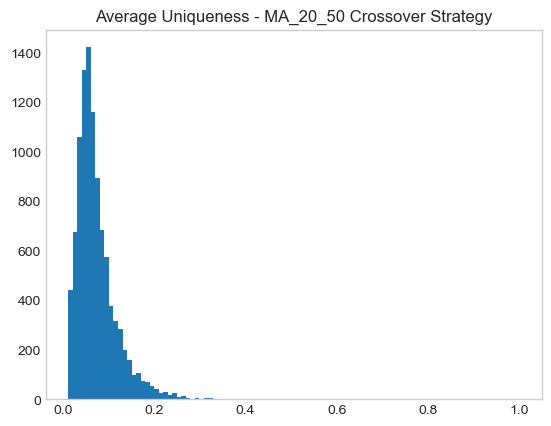

In [ ]:
cont_train["tW"].hist(bins=100, grid=False)
plt.title(f"Average Uniqueness - MA_{fast_window}_{slow_window} Crossover Strategy");

In [ ]:
cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)
cv_scores_d = {k: {} for k in clfs.keys()}
print(rf.__class__.__name__, "Weighting Schemes")
all_clf_scores_df = pd.DataFrame(dtype=pd.StringDtype())
best_models = []

for scheme, sample_weights in weighting_schemes.items():
    best_score, best_model = None, None
    for param, clf in clfs.items():
        w = sample_weights.values
        cv_scores = ml_cross_val_score(
            clf, X_train, y_train, cv_gen, 
            sample_weight_train=w, 
            sample_weight_score=w,
            scoring="f1",
        )
        score = cv_scores.mean()
        cv_scores_d[param][scheme] = score
        best_score = max(best_score, score) if best_score is not None else score
        if score == best_score:
            best_model = param
        all_clf_scores_df.loc[param, scheme] = f"{cv_scores.mean():.6f} ± {cv_scores.std():.4f}"
    best_models.append(best_model)
    print(f"{scheme} {best_model} model achieved the best f1 score of {best_score:.6f}")

print()
pprint(all_clf_scores_df, sort_dicts=False)
best_model = max(best_models, key=best_models.count)
best_clf = clone(clfs[best_model])
print(f"\nSelected Best Classifier ({best_model}): {best_clf}")

RandomForestClassifier Weighting Schemes
unweighted balanced_subsample model achieved the best f1 score of 0.405778
uniqueness balanced_subsample model achieved the best f1 score of 0.326313
return combined model achieved the best f1 score of 0.674708

                           unweighted         uniqueness             return
standard            0.000000 ± 0.0000  0.000000 ± 0.0000  0.480684 ± 0.1373
balanced_subsample  0.405778 ± 0.0620  0.326313 ± 0.0933  0.674708 ± 0.0518
max_samples         0.000000 ± 0.0000  0.000000 ± 0.0000  0.291804 ± 0.1409
combined            0.358043 ± 0.0838  0.249652 ± 0.1109  0.674708 ± 0.0518

Selected Best Classifier (balanced_subsample): RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       min_weight_fraction_leaf=0.05, n_jobs=-1,
                       random_state=42)


In [ ]:
all_cv_scores_d = {}
all_cms = {}
best_score, best_model = None, None
all_cv_scores_df = pd.DataFrame(dtype=pd.StringDtype())

for scheme, sample_weights in weighting_schemes.items():
    w = sample_weights.values
    cv_scores, cv_scores_df, cms = analyze_cross_val_scores(
        best_clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    score = cv_scores['f1'].mean()
    all_cv_scores_d[scheme] = cv_scores
    all_cms[scheme] = cms
    best_score = max(best_score, score) if best_score is not None else score
    if score == best_score:
        best_model = scheme
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores_df.loc[idx, scheme] = f"{row['mean']:.6f} ± {row['std']:.3f}"
pprint(all_cv_scores_df)
print(f"\n{best_model} model achieved the best f1 score of {best_score:.6f}\n")

                   unweighted       uniqueness           return
accuracy       0.5640 ± 0.081   0.6234 ± 0.070   0.5116 ± 0.063
pwa            0.5954 ± 0.103   0.7045 ± 0.070   0.5103 ± 0.065
neg_log_loss  -0.6810 ± 0.025  -0.6501 ± 0.024  -0.7781 ± 0.058
precision      0.3450 ± 0.036   0.3223 ± 0.046   0.5116 ± 0.063
recall         0.5335 ± 0.186   0.3749 ± 0.181   1.0000 ± 0.000
f1             0.4058 ± 0.062   0.3263 ± 0.093   0.6747 ± 0.052

return model achieved the best f1 score of 0.674708



In [ ]:
pprint(all_cms, sort_dicts=False)

{'unweighted': [{'fold': 1, 'TN': 393.0, 'FP': 328.0, 'FN': 110.0, 'TP': 185.0},
                {'fold': 2, 'TN': 483.0, 'FP': 248.0, 'FN': 158.0, 'TP': 127.0},
                {'fold': 3, 'TN': 450.0, 'FP': 279.0, 'FN': 156.0, 'TP': 131.0},
                {'fold': 4, 'TN': 578.0, 'FP': 161.0, 'FN': 187.0, 'TP': 90.0},
                {'fold': 5, 'TN': 139.0, 'FP': 482.0, 'FN': 80.0, 'TP': 315.0},
                {'fold': 6, 'TN': 336.0, 'FP': 419.0, 'FN': 91.0, 'TP': 170.0},
                {'fold': 7, 'TN': 518.0, 'FP': 229.0, 'FN': 158.0, 'TP': 111.0},
                {'fold': 8, 'TN': 596.0, 'FP': 127.0, 'FN': 205.0, 'TP': 88.0},
                {'fold': 9, 'TN': 480.0, 'FP': 267.0, 'FN': 150.0, 'TP': 119.0},
                {'fold': 10,
                 'TN': 129.0,
                 'FP': 554.0,
                 'FN': 41.0,
                 'TP': 292.0}],
 'uniqueness': [{'fold': 1, 'TN': 30.15, 'FP': 15.23, 'FN': 8.09, 'TP': 8.55},
                {'fold': 2, 'TN': 38.07, 'FP':

In [ ]:
winsound.Beep(1000, 1000)